In [1]:
import math
from astral import sun

import pandas as pd
import numpy as np
from astropy.coordinates import Angle
from astropy import units as u
from astropy.io.votable import parse
from astropy.io import ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astral import LocationInfo
import jupyter
from datetime import datetime, timedelta, timezone
from astropy.time import Time
import pytz

In [2]:
# function to take the long target names and make them shorter
def shorten_id(ID):
    s = ID.split("+") if "+" in ID else ID.split("-")
    return s[-1]

In [3]:
# globals
horizonBox = {  # {tuple(decWindow):tuple(minAlt,maxAlt)}
    (-35, -34): (-35, 42.6104),
    (-34, -32): (-35, 45.9539),
    (-32, -30): (-35, 48.9586),
    (-30, -28): (-35, 51.6945),
    (-28, -26): (-35, 54.2121),
    (-26, -24): (-35, 56.5487),
    (-24, -22): (-35, 58.7332),
    (-22, 0): (-35, 60),
    (0, 46): (-52.5, 60),
    (46, 56): (-37.5, 60),
    (56, 65): (-30, 60)
}

# dec_vertices = [item for key in horizonBox.keys() for item in key]  # this is just a list of integers, each being one member of one
dec_vertices = list(set([item for key in horizonBox.keys() for item in key]))  # this is just a list of integers, each being one member of one
# of the dec tuples that are the keys to the horizonBox dictionary
dec_vertices.sort()
print(dec_vertices)
locationInfo = LocationInfo(name="TMO", region="CA, USA",
                                        timezone="UTC",
                                        latitude=34.36,
                                        longitude=-117.63)

sidereal_rate = 360 / (23  * 3600 + 56 * 60 + 4.091)  # deg/second

[-35, -34, -32, -30, -28, -26, -24, -22, 0, 46, 56, 65]


In [72]:
def get_curent_sidereal_time():
    return Time(datetime.utcnow()).sidereal_time('mean', longitude=locationInfo.longitude)

# tmo observability functions (from maestro)
def siderealToDate(siderealAngle: Angle, current_sidereal_time: Angle):
    """!
    Convert an angle representing a sidereal time to UTC by relating it to local sidereal time
    @param siderealAngle: astropy Angle
    @param current_sidereal_time: the current sidereal time, also an astropy angle
    @return: datetime object, utc
    """
    # ---convert from sidereal to UTC---
    # find the difference between the sidereal observability start time and the sidereal start time of the program
    siderealFromStart = siderealAngle - current_sidereal_time
    # add that offset to the utc start time of the program (we know siderealStart is local sidereal time at startTime, so we use it as our reference)
    timeUTC = datetime.utcnow() + timedelta(
        hours=siderealFromStart.hour / 1.0027)  # one solar hour is 1.0027 sidereal hours

    return timeUTC

def dateToSidereal(dt: datetime, current_sidereal_time):
    timeDiff = dt - datetime.utcnow()
    sidereal_factor = 1.0027
    return current_sidereal_time + Angle(str(timeDiff.total_seconds()*sidereal_factor / 3600) + "h")

def toDecimal(angle: Angle):
    """!
    Return the decimal degree representation of an astropy Angle, as a float
    @return: Decimal degree representation, float
    """
    return round(float(angle.degree), 6)  # ew

def ensureFloat(angle):
    """!
    Return angle as a float, converting if necessary
    @rtype angle: float, Angle
    @return: decimal angle, as a float
    """
    try:
        if isinstance(angle, str) or isinstance(angle, tuple):
            angle = Angle(angle)
            return ensureFloat(angle)  # lol
    except:
        pass
    if isinstance(angle, float):
        return angle
    if isinstance(angle, Angle):
        return toDecimal(angle)
    else:
        return float(angle)

def getHourAngleLimits(dec):
    """
    Get the hour angle limits of the target's observability window based on its dec.
    @param dec: float, int, or astropy Angle
    @return: A tuple of Angle objects representing the upper and lower hour angle limits
    """
    dec = ensureFloat(dec)
    for decRange in horizonBox:
        if decRange[0] < dec <= decRange[1]:  # man this is miserable
            finalDecRange = horizonBox[decRange]
            return tuple([Angle(finalDecRange[0], unit=u.deg), Angle(finalDecRange[1], unit=u.deg)])
    return None


def ensureAngle(angle):
    """!
    Return angle as an astropy Angle, converting if necessary
    @param angle: float, int, hms Sexagesimal string, hms tuple, or astropy Angle
    @return: angle, as an astropy Angle
    """
    if not isinstance(angle, Angle):
        try:
            if isinstance(angle, str) or isinstance(angle, tuple):
                angle = Angle(angle)
            else:
                angle = Angle(angle, unit=u.deg)
        except Exception as err:
            print("Error converting", angle, "to angle")
            raise err
    return angle

def angleToTimedelta(angle: Angle):  # low precision
    """!
    Convert an astropy Angle to an timedelta whose duration matches the hourangle of the angle
    @rtype: timedelta
    """
    angleTime = angle.to(u.hourangle)
    angleHours, angleMinutes, angleSeconds = angleTime.hms
    return timedelta(hours=angleHours, minutes=angleMinutes, seconds=0)

def findTransitTime(rightAscension: Angle, location, target_dt=None, current_sidereal_time=None):
    """!Calculate the transit time of an object at the given location.

    @param rightAscension: The right ascension of the object as an astropy Angle
    @type rightAscension: Angle
    @param location: The observatory location.
    @type location: astral.LocationInfo
    @param target_dt: find the next transit after this time. if None, uses currentTime
    @param current_sidereal_time: the current sidereal time, as an astropy angle. will be calculated (slow) if not provided
    @return: The transit time of the object as a datetime object.
    @rtype: datetime.datetime
    """

    currentTime = datetime.utcnow().replace(second=0, microsecond=0)
    if current_sidereal_time is None:
        lst = Time(currentTime).sidereal_time('mean', longitude=location.longitude)
    else:
        lst = current_sidereal_time
    target_time = target_dt.replace(second=0, microsecond=0) or currentTime
    target_sidereal_time = dateToSidereal(target_time,lst)
    ha = rightAscension - target_sidereal_time
    transitTime = target_time + angleToTimedelta(ha)
    return transitTime

def staticObservabilityWindow(RA: Angle, Dec: Angle, locationInfo: LocationInfo, target_dt=None, current_sidereal_time=None):
    """!
    Generate the TMO observability window for a static target based on RA, dec, and location
    @param RA: right ascension
    @param Dec: declination
    @param locationInfo: astral LocationInfo object for the observatory site
    @param target_dt: find the next transit after this time. if None, uses currentTime
    @param current_sidereal_time: the current sidereal time. will add sidereal days to this if necessary
    @return: [startTime, endTime]
    @rtype: list(datetime)
    """
    if current_sidereal_time is None:
        currentTime = datetime.utcnow().replace(second=0, microsecond=0)
        lst = Time(datetime.utcnow()).sidereal_time('mean', longitude=locationInfo.longitude)
    target_dt = target_dt or datetime.utcnow()
    t = findTransitTime(ensureAngle(float(RA)), locationInfo, current_sidereal_time=current_sidereal_time,target_dt=target_dt)
    timeWindow = (angleToTimedelta(a) for a in getHourAngleLimits(Dec))
    return [t + a for a in timeWindow]
    # HA = ST - RA -> ST = HA + RA


def wrap_around(value):
    a = -180
    b = 180
    return (value - a) % (b-a) + a

# get hour angle, in
def get_hour_angle(ra,dt,current_sidereal_time):
    sidereal = dateToSidereal(dt,current_sidereal_time)
    return Angle(wrap_around((ra-sidereal).deg),unit=u.deg)

def getSunriseSunset(dt=datetime.utcnow()):
    """!
    get sunrise and sunset for TMO
    @return: sunriseUTC, sunsetUTC
    @rtype: datetime.datetime
    """
    dt = pytz.UTC.localize(dt)
    s = sun.sun(locationInfo.observer, date=dt, tzinfo=timezone.utc)
    sunriseUTC = s["sunrise"]
    sunsetUTC = sun.time_at_elevation(locationInfo.observer, -10, direction=sun.SunDirection.SETTING,date=dt)

    # TODO: make this less questionable - it probably doesn't do exactly what i want it to when run at certain times of the day:
    if sunriseUTC < dt:  # if the sunrise we found is earlier than the current time, add one day to it (approximation ofc)
        sunriseUTC = sunriseUTC + timedelta(days=1)

    if sunsetUTC > sunriseUTC:
        sunsetUTC = sunsetUTC - timedelta(days=1)

    return sunriseUTC, sunsetUTC


def get_RA_window(current_sidereal_time, target_dt, dec, ra=None):
    # get the bounding RA coordinates of the TMO observability window for time target_dt for targets at declination dec. Optionally, input an RA to also get out that RA, adjusted for box-shifting

    adjusted_ra = ra.copy() if ra is not None else None
    hourAngleWindow = getHourAngleLimits(dec)
    if not hourAngleWindow: return False
    raWindow = [dateToSidereal(target_dt, current_sidereal_time) - hourAngleWindow[1],
                (dateToSidereal(target_dt, current_sidereal_time) - hourAngleWindow[0]) % Angle(360, unit=u.deg)]

    # we want something like (23h to 17h) to look like [(23h to 24h) or (0h to 17h)] so we move the whole window to start at 0 instead
    if raWindow[0] > raWindow[1]:
        diff = Angle(24, unit=u.hour) - raWindow[0]
        raWindow[1] += diff
        if adjusted_ra is not None:
            adjusted_ra = (adjusted_ra + diff) % Angle(360, unit=u.deg)
        raWindow[0] = Angle(0, unit=u.deg)
    return raWindow, adjusted_ra


def observationViable(dt: datetime, ra: Angle, dec: Angle, current_sidereal_time=None,locationInfo=None):
    """
    Can a target with RA ra and Dec dec be observed at time dt? Checks hour angle limits based on TMO bounding box.
    @return: bool
    """
    if current_sidereal_time is None:
        current_sidereal_time = Time(datetime.utcnow()).sidereal_time('mean', longitude=locationInfo.longitude)
    HA_window = getHourAngleLimits(dec)
    HA = get_hour_angle(ra,dt,current_sidereal_time)
    # NOTE THE ORDER:
    return HA.is_within_bounds(HA_window[0], HA_window[1])


# def observationViable(dt: datetime, ra: Angle, dec: Angle, current_sidereal_time=None,locationInfo=None):
#     """
#     Can a target with RA ra and Dec dec be observed at time dt? Checks hour angle limits based on TMO bounding box.
#     @return: bool
#     """
#     if current_sidereal_time is None:
#         current_sidereal_time = Time(datetime.utcnow()).sidereal_time('mean', longitude=locationInfo.longitude)
#     raWindow, rac = get_RA_window(current_sidereal_time,dt,dec,ra=ra)
#     # NOTE THE ORDER:
#     return rac.is_within_bounds(raWindow[0], raWindow[1])

In [66]:
# import data - these targets have been downselected to ones that have the potential to be visible
table = Table.read('data/christ_table.csv', format='ascii.csv')

coordinates = SkyCoord(table['RA_2000'], table['Dec_2000'], unit=(u.hourangle, u.deg))

table['RA_2000_deg'] = coordinates.ra.deg
table['Dec_2000_deg'] = coordinates.dec.deg
table["ShortID"] = [shorten_id(ID) for ID in table["ID"]]
table.write('data/christ_table_degrees.csv', format='ascii.csv', overwrite=True)

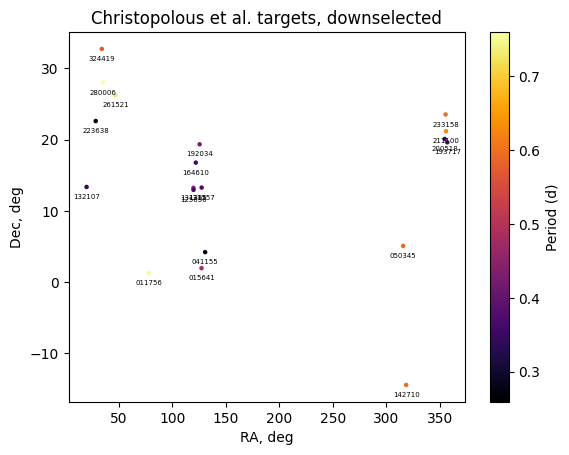

In [67]:
# plot setup
fig, ax = plt.subplots()
ax.set(xlabel="RA, deg", ylabel="Dec, deg", title="Christopolous et al. targets, downselected")

# plot the points
scatter = ax.scatter(table["RA_2000_deg"], table["Dec_2000_deg"], c=table["Period"], cmap="inferno",s=5)
cbar = plt.colorbar(scatter, label='Period (d)')

# label the points
for i, label in enumerate(table["ShortID"]):
    plt.annotate(label, (table["RA_2000_deg"][i], table["Dec_2000_deg"][i]), textcoords="offset points", xytext=(0, -5),fontsize=5, ha='center',va='top')


plt.show()

In [68]:
current_sidereal_time = get_curent_sidereal_time()

In [69]:
# this line is slow - you can uncomment it to get better precision at a slightly increased runtime. otherwise, accuracy will be limited by the recentness with which you ran the previous cell.
current_sidereal_time = get_curent_sidereal_time()

def get_centroid(points):
    x, y = zip(*points)
    centroid_x = sum(x) / len(points)
    centroid_y = sum(y) / len(points)
    return centroid_x, centroid_y

# define a function to calculate the angle between two points and the centroid
def get_angle(point1, point2, centroid):
    angle1 = math.atan2(point1[1] - centroid[1], point1[0] - centroid[0])
    angle2 = math.atan2(point2[1] - centroid[1], point2[0] - centroid[0])
    return angle1 - angle2


def get_horizon_box_vertices(dt):
    horizon_box_vertices = []
    for dec in dec_vertices:
        for offset in (0.5,-0.5):
            window = getHourAngleLimits(dec+offset)
            if not window:
                continue
            window = [a.deg for a in window]
            horizon_box_vertices.append((window[0],dec))
            horizon_box_vertices.append((window[1],dec))
    # put the vertices in clockwise order

    # find the centroid of the points
    centroid = get_centroid(horizon_box_vertices)
    # sort the points based on their angles with respect to the centroid
    ordered_vertices = sorted(horizon_box_vertices, key=lambda point: get_angle(point, centroid, centroid))
    # append the first vertex at the end to close the polygon
    ordered_vertices.append(ordered_vertices[0])
    # fix annoying shape malformation
    ordered_vertices[42], ordered_vertices[43] = ordered_vertices[43], ordered_vertices[42]

    return ordered_vertices


def vertices_to_x_and_y(vertices):
    # take a list of tuples and return two lists, one of the x coords and one of the y coords
    return zip(*vertices)

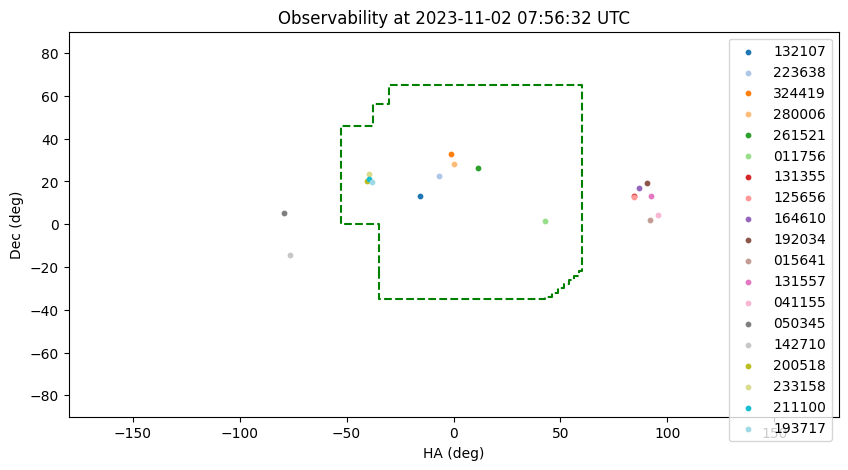

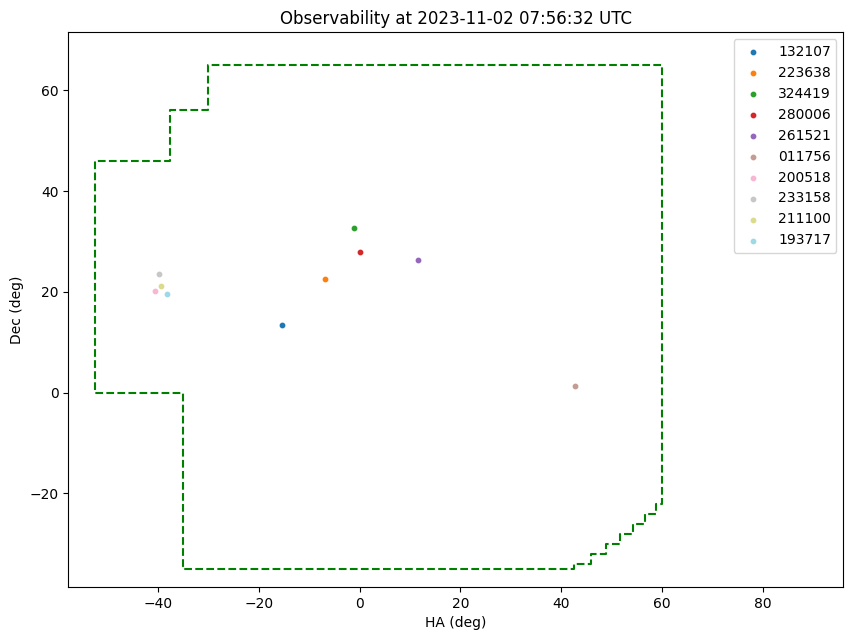

In [75]:
from shapely import Polygon
sunrise, sunset = getSunriseSunset()
dt = sunset.replace(tzinfo=None)+(sunrise-sunset)/2
# get the current horizon box
horizon_vertices = get_horizon_box_vertices(dt)
# calculate hour angles
table["HA"] = [get_hour_angle(Angle(ra,unit='deg'),dt,current_sidereal_time).deg for ra in table["RA_2000_deg"]]
# make column indicating which targets are observable
table["Observable"] = [observationViable(dt-timedelta(days=1),Angle(row["RA_2000_deg"],unit='deg'),Angle(row["Dec_2000_deg"],unit='deg'), current_sidereal_time=current_sidereal_time) for row in table]

x,y = vertices_to_x_and_y(horizon_vertices)
# graph min needs to become more negative if already negative else less positive
min_coeff = 1.1 if min(x) < 0 else 0.9

xlims = [(-180,180),(min_coeff*min(x),1.6*max(x))]
min_coeff = 1.1 if min(y) < 0 else 0.9
ylims = [(-90,90),(min_coeff*min(y),1.1*max(y))]
figsizes = [(20,5),(10,10)]
tables = [table,table[table["Observable"]]]
for data, figsize, xlimits, ylimits in zip(tables, figsizes,xlims,ylims):
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the polygon outline
    ax.plot(x, y, color='green', linestyle='dashed')
    colors = plt.cm.tab20(np.linspace(0, 1, len(data)))

    for i, row in enumerate(data):
        scatter = ax.scatter(row["HA"], row["Dec_2000_deg"], c=[colors[i]], label=row["ShortID"],s=10)
    # cbar = plt.colorbar(scatter, label='Period (d)')

    plt.legend()
    # label the points
    # for i, label in enumerate(table["ShortID"]):
    #     plt.annotate(label, (table["HA"][i], table["Dec_2000_deg"][i]), textcoords="offset points", xytext=(0, -5),fontsize=10, ha='center',va='top')

    plt.title(f"Observability at {dt.strftime('%Y-%m-%d %H:%M:%S')} UTC")
    # Set axis labels if needed
    ax.set_xlabel('HA (deg)')
    ax.set_ylabel('Dec (deg)')
    plt.axis('scaled')
    ax.set_xlim(*xlimits)
    ax.set_ylim(*ylimits)
    # Show the plot
    plt.show()

Animated!
Animated!


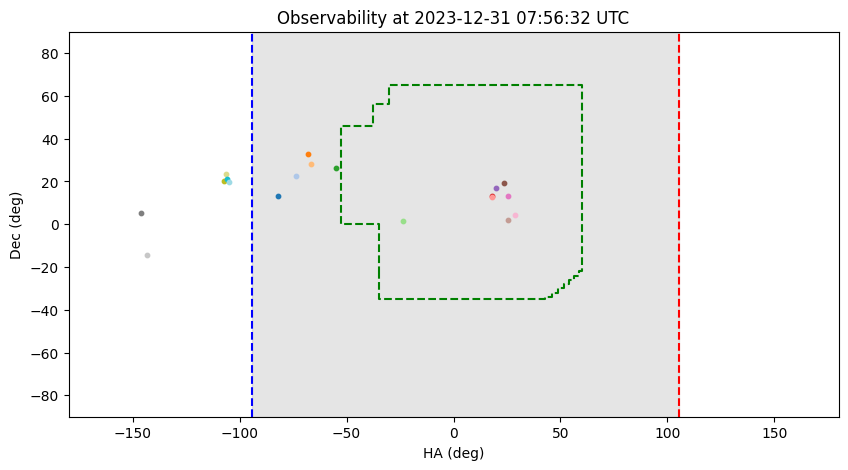

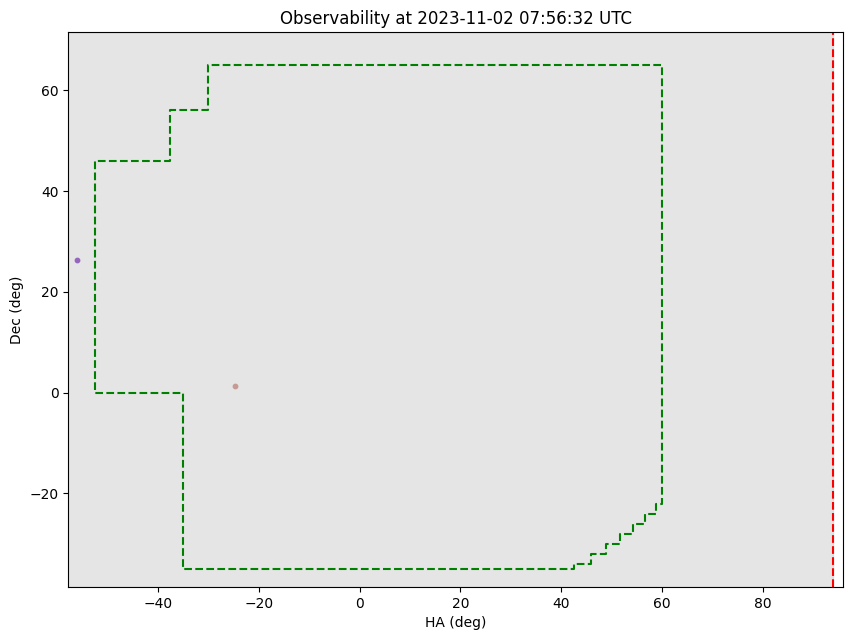

In [83]:
import matplotlib.animation as animation

nframes = 60
sidereal_day = 1/1.0027
timestep = timedelta(days=1)
# timestep = timedelta(days=90*sidereal_day/nframes)  # epic division by zero
sunrise, sunset = [t.replace(tzinfo=None) for t in getSunriseSunset()]
dt = sunset + 1/2 * (sunrise-sunset)
# get the current horizon box
horizon_vertices = get_horizon_box_vertices(dt)
# calculate hour angles
table["HA"] = [get_hour_angle(Angle(ra,unit='deg'),dt,current_sidereal_time).deg for ra in table["RA_2000_deg"]]
# make column indicating which targets are observable
table["Observable"] = [observationViable(dt,Angle(row["RA_2000_deg"],unit='deg'),Angle(row["Dec_2000_deg"],unit='deg'), current_sidereal_time=current_sidereal_time) for row in table]


x,y = vertices_to_x_and_y(horizon_vertices)
# graph min needs to become more negative if already negative else less positive
min_coeff = 1.1 if min(x) < 0 else 0.9

xlims = [(-180,180),(min_coeff*min(x),1.6*max(x))]
min_coeff = 1.1 if min(y) < 0 else 0.9
ylims = [(-90,90),(min_coeff*min(y),1.1*max(y))]
figsizes = [(10,5),(10,10)]
tables = [table,table[table["Observable"]]]
for data, figsize, xlimits, ylimits in zip(tables, figsizes,xlims,ylims):

    fig, ax = plt.subplots(figsize=figsize)

    # Plot the polygon outline
    colors = plt.cm.tab20(np.linspace(0, 1, len(data)))
    ax.set_xlabel('HA (deg)')
    ax.set_ylabel('Dec (deg)')
    plt.axis('scaled')
    ax.set_xlim(*xlimits)
    ax.set_ylim(*ylimits)
    # draw the ha box
    ax.plot(x, y, color='green', linestyle='dashed')
    # initial hour angles
    HA = [get_hour_angle(Angle(ra,unit='deg'),dt,current_sidereal_time).deg for ra in data["RA_2000_deg"]]

    def update(frame):
        global HA

        time = dt + timestep * frame

        ax.cla()
        ax.set_xlabel('HA (deg)')
        ax.set_ylabel('Dec (deg)')
        plt.axis('scaled')
        ax.set_xlim(*xlimits)
        ax.set_ylim(*ylimits)
        plt.title(f"Observability at {time.strftime('%Y-%m-%d %H:%M:%S')} UTC")

        sunrise, sunset = getSunriseSunset(time)
        sunrise, sunset = dateToSidereal(sunrise.replace(tzinfo=None),current_sidereal_time), dateToSidereal(sunset.replace(tzinfo=None), current_sidereal_time)
        sidereal = dateToSidereal(time,current_sidereal_time)
        sunrise, sunset = sunrise-sidereal, sunset-sidereal
        sunrise, sunset = wrap_around(sunrise.deg), wrap_around(sunset.deg)
        sunrise_line = ax.axvline(x=sunrise, linestyle='--', color='red')
        sunset_line = ax.axvline(x=sunset, linestyle='--', color='blue')

        if sunset < sunrise:
            fill = ax.axvspan(sunset, sunrise, alpha=0.2, color='gray')
        else:
            fill1 = ax.axvspan(xlimits[0],sunrise,alpha=0.2,color="gray")
            fill2 = ax.axvspan(sunset,xlimits[1],alpha=0.2,color="gray")

        HA = [wrap_around(ha-sidereal_rate*timestep.total_seconds()) for ha in HA]

        artists = [ax.plot(x, y, color='green', linestyle='dashed'),sunrise_line,sunset_line]
        for i, row in enumerate(data):
            artists.append(ax.scatter(HA[i], row["Dec_2000_deg"], c=[colors[i]], label=row["ShortID"],s=10))
        return artists

    ani = animation.FuncAnimation(fig=fig, func=update, frames=nframes, interval=10, repeat=True)
    ani.save(filename=f"observability_{xlimits[1]}.gif", writer="pillow")
    print("Animated!")

In [ ]:
current_sidereal_time = get_curent_sidereal_time()
nframes = 50
sidereal_day = 1/1.0027
xlimits = (-180,180)
ra = Angle(table["RA_2000_deg"][0],unit='deg')
for frame in range(10*nframes):
    time = dt + timedelta(days=(sidereal_day/nframes))*frame
    ha = get_hour_angle(ra,time,current_sidereal_time).deg
    plt.scatter(time,ha)
plt.show()

In [ ]:
now = datetime.utcnow()

def dateToAngle(dt):
    timeDiff = dt - datetime.utcnow()
    return current_sidereal_time + Angle(str(timeDiff.total_seconds()/ 3600) + "h")

for i in range(730):
    date = now + timedelta(days=1)*i
    sunrise, sunset = [wrap_around(dateToAngle(t.replace(tzinfo=None)).deg) for t in getSunriseSunset(date)]
    plt.scatter(date, sunrise,c="red")
    plt.scatter(date, sunset,c="blue")
plt.show()

In [84]:
table["Observable"] = [observationViable(dt+timedelta(days=10),Angle(row["RA_2000_deg"],unit='deg'),Angle(row["Dec_2000_deg"],unit='deg'), current_sidereal_time=current_sidereal_time) for row in table]

obs_table = table[table["Observable"]]
obs_table.write("observability.csv",overwrite=True)



In [85]:
import juliandate as jd, jdcal
HJD_0 = 2450000

def julianToDatetime(hjd):
    time = Time(hjd, format='jd', scale='tdb')
    return time.to_datetime()

def datetimeToJulian(datetime):
  return Time(datetime).jd


In [86]:
obs_table["Epoch_dt"] = julianToDatetime(obs_table["EpochHJD"]+HJD_0)

In [87]:
obs_table["Epoch_dt"]

2013-10-24 07:03:09.504008
2005-10-10 07:51:03.168003
2009-10-16 10:03:23.327993
2007-11-01 07:34:04.512011
2011-03-28 02:55:07.103983
2005-11-29 06:14:07.584017


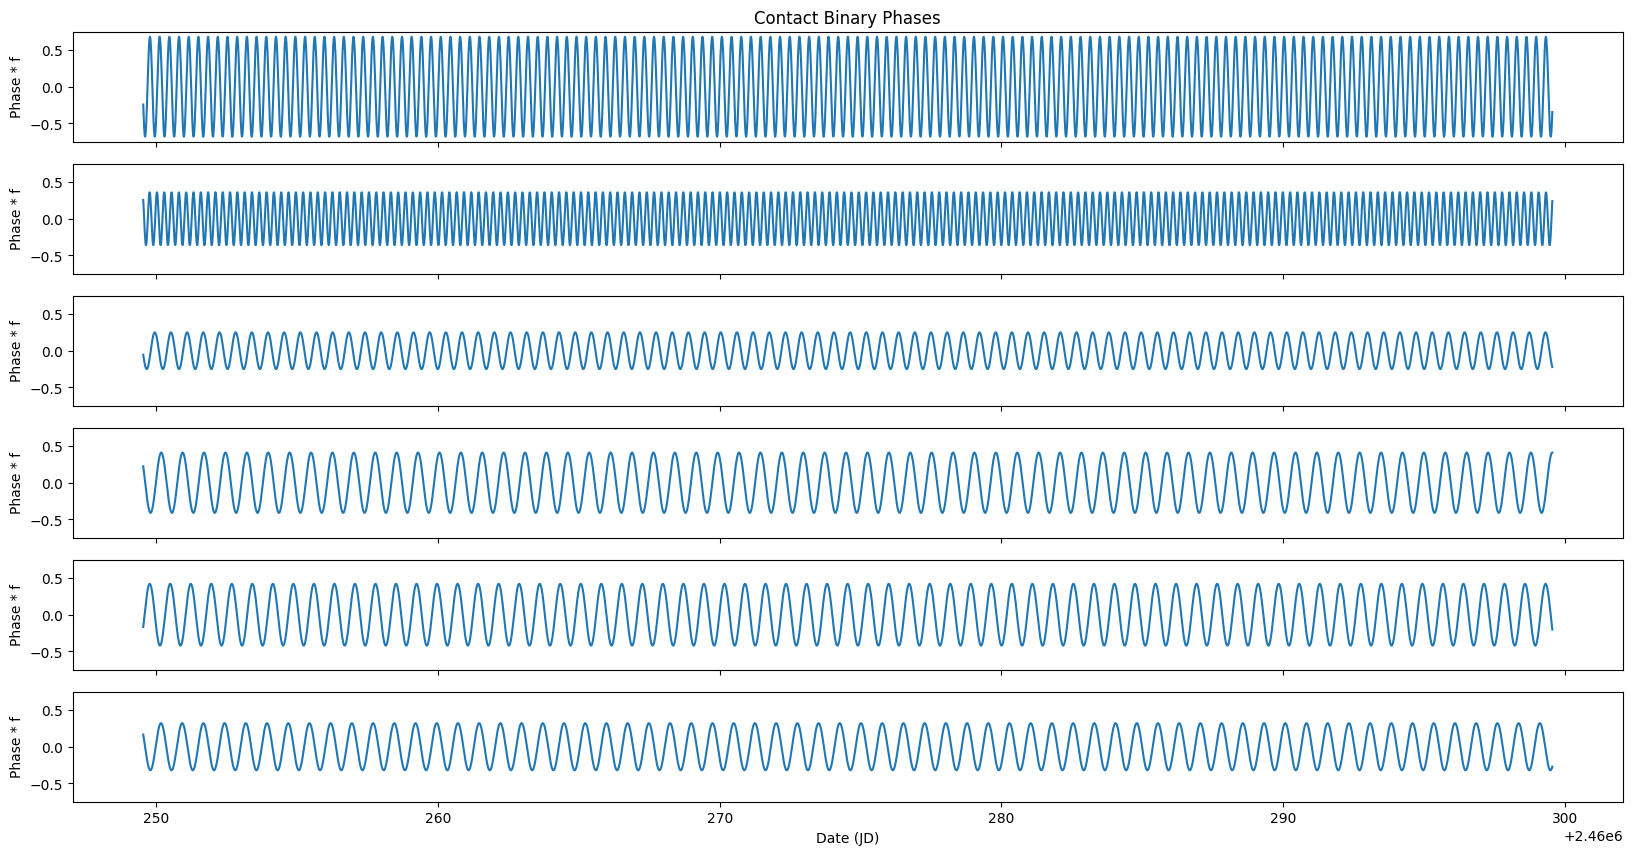

In [94]:
fig, axes = plt.subplots(len(obs_table),figsize=(20,10),sharex=True,sharey=True)
times = np.linspace(2460249.54653,2460249.54653+50,num=5000)
axes[0].set_title("Contact Binary Phases")
for row, ax in zip(obs_table,axes):
    epoch = row["EpochHJD"]
    period = row["Period"]
    coverage = row["f"]
    B = 2*math.pi/period
    f = np.vectorize(lambda x: coverage * math.sin(B*(x+epoch)))
    ax.plot(times,f(times))
    ax.set_ylabel("Phase * f")

axes[-1].set_xlabel("Date (JD)")
plt.show()